In [458]:
import xarray as xr
import numpy as np
from minisom import MiniSom
import pandas as pd
from sklearn.preprocessing import RobustScaler
import pprint
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec 
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm
import matplotlib.gridspec as gridspec 
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

from som_2var_training import read_and_transform, build_scaler, train_som

# Very messy but this contains all the stats stuff we were doing for CIRCS.

In [459]:
prefs = {'filename': "./../Datasets/Combined/spring_z500_td2m.nc", 
         'var1': 'z500', 'var2': 'td2m', 'wlon': 220, 'elon': 305, 'nlat': 55, 'slat': 20, 
         'som_config': {'x': 2, 'y': 2, 'sigma': 0.5, 'random_seed': 42},
         'som_train': {'num_iteration': 10000, 'random_order': True, 'verbose': True}}

trained_som, trained_scaler, train_info, xr_data = train_som(prefs)


current model configuration
{'input_len': 24282, 'random_seed': 42, 'sigma': 0.5, 'x': 2, 'y': 2}
current training configuration
{'data': array([[-0.712504  , -0.7123801 , -0.6898653 , ..., -4.009091  ,
        -4.076801  , -3.9931393 ],
       [-0.04435258, -0.08802831, -0.11636167, ..., -0.56666666,
        -0.74240017, -0.80274475],
       [-0.02644878, -0.02472697, -0.01121567, ..., -1.8121206 ,
        -1.968     , -2.1543741 ],
       ...,
       [ 0.        , -0.01418204, -0.01238249, ..., -0.88181764,
        -1.0400007 , -1.1835339 ],
       [ 0.97334176,  0.9745891 ,  0.9802888 , ...,  0.2939392 ,
         0.33599955,  0.36020532],
       [ 1.0152553 ,  1.0167688 ,  1.0188868 , ...,  0.6030304 ,
         0.71360034,  0.8233274 ]], dtype=float32),
 'num_iteration': 10000,
 'random_order': True,
 'verbose': True}
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 101.86310869602737


In [460]:
win_map = trained_som.win_map(train_info['som_train']['data'])

z500_avg_data = [
    np.reshape(
        trained_scaler.inverse_transform([np.mean(win_map[node], axis=0)])[0][:12141],
        (len(xr_data.lat), len(xr_data.lon))
    )
    for node in sorted(win_map.keys())
]

z500_frequencies = trained_som.activation_response(train_info['som_train']['data']).flatten()


pwat_avg_data = [
    np.reshape(
        trained_scaler.inverse_transform([np.mean(win_map[node], axis=0)])[0][12141:],
        (len(xr_data.lat), len(xr_data.lon))
    )
    for node in sorted(win_map.keys())
]

pwat_frequencies = trained_som.activation_response(train_info['som_train']['data']).flatten()


length, width = prefs['som_config']['x'], prefs['som_config']['y']

In [461]:
ds, npy, scaler = build_scaler(prefs)

scaled_npy = scaler.transform(npy)

In [462]:
def find_best_samples(scaled_npy, trained_som):
    
    weights = trained_som.get_weights() # shape (nx, ny, 2*(lat*lon), represents the weight vector of each node
    
    nx, ny, nfeats = weights.shape 
    
    win_map_idx = trained_som.win_map(scaled_npy, return_indices=True)

    closest_match_idx = {}

    for i in range(nx):
        for j in range(ny):
            idx = np.asarray(win_map_idx[(i, j)], dtype=int)
            diffs = scaled_npy[idx] - weights[i, j]       # Compute difference for linalg.norm
            d = np.linalg.norm(diffs, axis=1)             # Euclidean distances (K,)
            best = idx[np.argmin(d)]                       # this is the best sample index in scaled_npy

            closest_match_idx[(i, j)] = best

    return closest_match_idx, win_map_idx

In [463]:
ds_tor = xr.open_dataset('./../Datasets/P_Per/pper_tor_1979_2023.nc')
ds_wind = xr.open_dataset('./../Datasets/P_Per/pper_wind_1979_2023.nc')
ds_hail = xr.open_dataset('./../Datasets/P_Per/pper_hail_1979_2023.nc')

In [464]:
best_samples, win_map_idx = find_best_samples(scaled_npy, trained_som)

In [465]:
len(win_map_idx.keys())

4

In [466]:
for key in win_map_idx.keys():
    for timestep in win_map_idx[key]:
        
        tor = []
        wind = []
        hail = []
        
        date_sel= ds.time[0]
        
        ds_tor_sel= ds_tor.sel(time= date_sel.time.values - 1, method= 'nearest')
        ds_wind_sel= ds_wind.sel(time= date_sel.time.values - 1, method= 'nearest')
        ds_hail_sel= ds_hail.sel(time= date_sel.time.values - 1, method= 'nearest')
        
        tor_mean = ds_tor_sel.p_perfect_tor.mean()
        wind_mean = ds_wind_sel.p_perfect_wind.mean()
        hail_mean = ds_hail_sel.p_perfect_hail.mean()
        
        tor.append(tor_mean.values)
        wind.append(wind_mean.values)
        hail.append(hail_mean.values)
        

In [467]:
date_sel = ds.time[0]

In [468]:
ds_tor.sel(time= date_sel.time.values - 1, method= 'nearest')

<xarray.Dataset>
Dimensions:        (x: 93, y: 65)
Coordinates:
    time           datetime64[ns] 2000-02-29T12:00:00
  * x              (x) float64 0.0 1.0 2.0 3.0 4.0 ... 88.0 89.0 90.0 91.0 92.0
  * y              (y) float64 0.0 1.0 2.0 3.0 4.0 ... 60.0 61.0 62.0 63.0 64.0
Data variables:
    lat            (y, x) float64 ...
    lon            (y, x) float64 ...
    p_perfect_tor  (y, x) float64 ...
Attributes:
    title:         Practically Perfect Tor Hindcasts
    grid:          80-km NCEP 211
    sigma:         1.5
    author:        Dr. Victor Gensini
    author_email:  vgensini@niu.edu
    citation:      https://doi.org/10.1175/BAMS-D-19-0321.1

In [469]:
z500_frequencies

array([ 55., 107.,  47.,  54.])

In [470]:
len(tor)

1

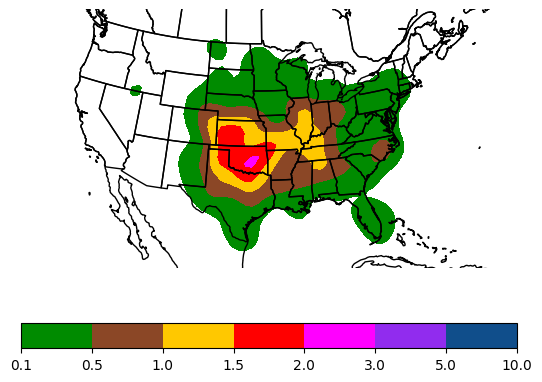

In [471]:
date_sel = ds.time[win_map_idx[0, 1]]

ds_tor_sel = ds_tor.sel(time= date_sel.time.values - 1, method= 'nearest')

mean = ds_tor_sel.p_perfect_tor.mean(dim= 'time')

colors = ['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b']
levels = [0.1, 0.5, 1, 1.5, 2.0, 3, 5, 10]

ax = plt.subplot(1, 1, 1, projection= ccrs.LambertConformal())
ax.set_extent([-122, -67, 20, 50])
c = ax.contourf(ds_tor_sel.lon, ds_tor_sel.lat, mean, colors= colors, levels= levels, transform= ccrs.PlateCarree())
ax.add_feature(cfeature.STATES)
ax.coastlines()
ax.axis('OFF')

plt.colorbar(c, orientation= 'horizontal')

plt.show()

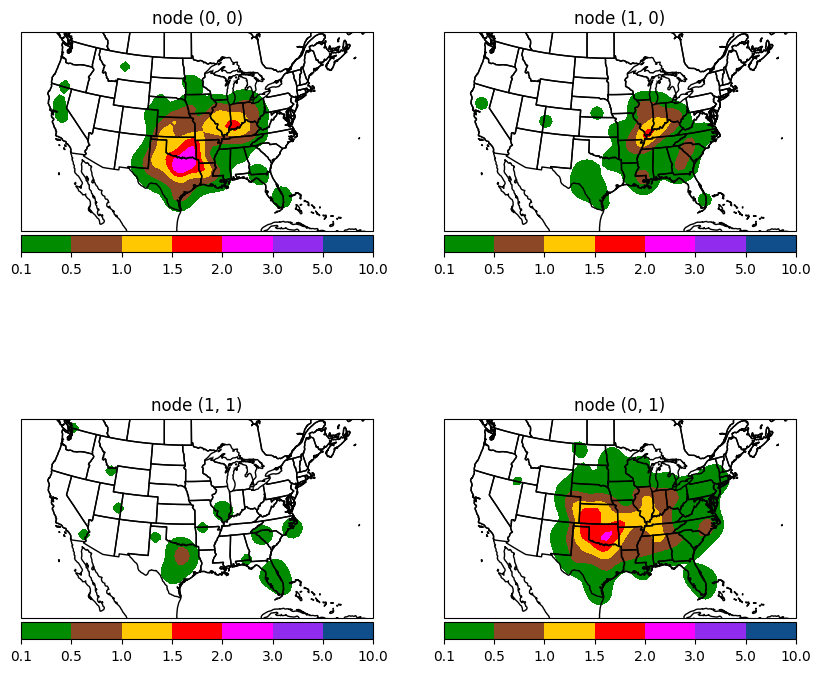

In [472]:
fig = plt.figure(figsize= (10, 10))


for i, key in enumerate(win_map_idx.keys()):
    date_sel = ds.time[win_map_idx[key]]

    ds_tor_sel = ds_tor.sel(time= date_sel.time.values - 1, method= 'nearest')

    mean = ds_tor_sel.p_perfect_tor.mean(dim= 'time')

    colors = ['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b']
    levels = [0.1, 0.5, 1, 1.5, 2.0, 3, 5, 10]

    ax = plt.subplot(2, 2, i+1, projection= ccrs.LambertConformal())
    ax.set_extent([-122, -67, 20, 50])
    c = ax.contourf(ds_tor_sel.lon, ds_tor_sel.lat, mean, colors= colors, levels= levels, transform= ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES)
    ax.coastlines()
    ax.set_title(f'node {key}')
    plt.colorbar(c, orientation= 'horizontal', pad= 0.01)
    
fig.subplots_adjust(hspace= 0.01)    
plt.show()

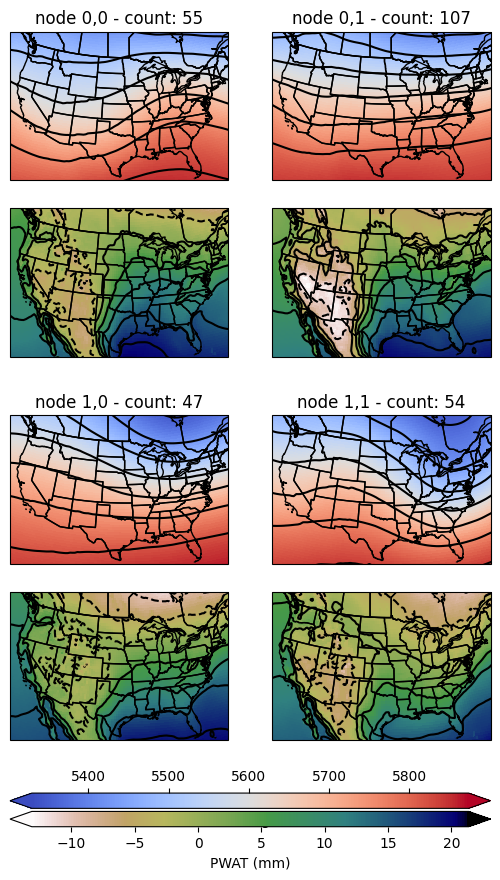

In [473]:
import matplotlib.gridspec as gridspec

# np.reshape(z500_avg_data, (4, 4, 71, 171))
# np.reshape(pwat_avg_data, (4, 4, 71, 171))

vmin_z500 = np.min(z500_avg_data)
vmax_z500 = np.max(z500_avg_data)
norm_z500 = mcolors.Normalize(vmin= vmin_z500, vmax= vmax_z500)

vmin_pwat = np.min(pwat_avg_data)
vmax_pwat = np.max(pwat_avg_data)
norm_pwat = mcolors.Normalize(vmin=vmin_pwat, vmax=vmax_pwat)


fig = plt.figure(figsize=(3.1 * length, 2 * 2.6 * width))


outer = GridSpec(nrows= length + 1, ncols= width, figure= fig, height_ratios = [1] * length + [0.1])

for i in range(length):
    for j in range(width):
        node_idx = i * width + j
        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i, j], hspace= 0.1, wspace= 0.05)
        
        ax_z500 = fig.add_subplot(inner[0,0], projection= ccrs.LambertConformal())
        ax_z500.set_title(f'node {i},{j} - count: {int(pwat_frequencies[node_idx])}')
        ax_z500.set_extent([xr_data.lon.values.min() - 340, xr_data.lon.values.max() - 380, xr_data.lat.values.min() + 3, xr_data.lat.values.max() - 3])
        zcm = ax_z500.pcolormesh(xr_data.lon, xr_data.lat, z500_avg_data[node_idx], cmap= 'coolwarm', transform= ccrs.PlateCarree())
        zct = ax_z500.contour(xr_data.lon, xr_data.lat, z500_avg_data[node_idx], colors= 'k', transform= ccrs.PlateCarree())
        ax_z500.add_feature(cfeature.BORDERS)
        ax_z500.add_feature(cfeature.STATES)
        
        ax_pwat = fig.add_subplot(inner[1, 0], projection= ccrs.LambertConformal())
        ax_pwat.set_extent([xr_data.lon.values.min() - 340, xr_data.lon.values.max() - 380, xr_data.lat.values.min() + 3, xr_data.lat.values.max() - 3])
        pcm = ax_pwat.pcolormesh(xr_data.lon, xr_data.lat, pwat_avg_data[node_idx], cmap= 'gist_earth_r', transform= ccrs.PlateCarree())
        pct = ax_pwat.contour(xr_data.lon, xr_data.lat, pwat_avg_data[node_idx], colors= 'k', transform= ccrs.PlateCarree())
        ax_pwat.add_feature(cfeature.BORDERS)
        ax_pwat.add_feature(cfeature.STATES)


cax_inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec= outer[-1, :])        
cax_z500 = fig.add_subplot(cax_inner[0, 0])
cax_pwat = fig.add_subplot(cax_inner[1, 0])

cb_z500 = fig.colorbar(zcm, cax= cax_z500, orientation= 'horizontal', extend= 'both')
cb_z500.ax.xaxis.set_ticks_position('top')
cb_z500.ax.xaxis.set_ticks_position('top')
cb_z500.ax.tick_params(labeltop= True, labelbottom= False)
cb_z500.set_label('500 hPa heights (m)')
fig.colorbar(pcm, cax= cax_pwat, orientation= 'horizontal', extend= 'both', label= 'PWAT (mm)')
#plt.savefig('./figs/combined_z500_pwat.png', bbox_inches= 'tight')

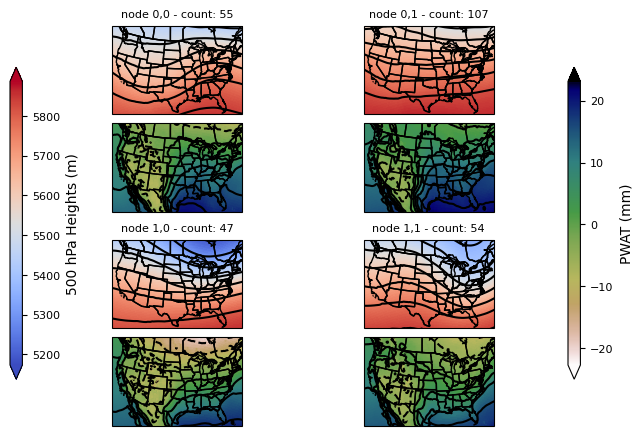

In [474]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Normalizations
vmin_z500 = np.min(z500_avg_data)
vmax_z500 = np.max(z500_avg_data)
norm_z500 = mcolors.Normalize(vmin=vmin_z500, vmax=vmax_z500)

vmin_pwat = np.min(pwat_avg_data)
vmax_pwat = np.max(pwat_avg_data)
norm_pwat = mcolors.Normalize(vmin=vmin_pwat, vmax=vmax_pwat)

# Figure + gridspec layout
fig = plt.figure(figsize=(3.1 * width, 2.6 * length))
outer = gridspec.GridSpec(
    nrows=length, ncols=width, 
    figure=fig, wspace=0.1, hspace=0.15
)

# Plotting each node
for i in range(length):
    for j in range(width):
        node_idx = i * width + j
        inner = gridspec.GridSpecFromSubplotSpec(
            2, 1, subplot_spec=outer[i, j], hspace=0.1
        )

        # Z500 plot
        ax_z500 = fig.add_subplot(inner[0, 0], projection=ccrs.LambertConformal())
        ax_z500.set_title(f'node {i},{j} - count: {int(pwat_frequencies[node_idx])}', fontsize=8)
        ax_z500.set_extent([
            xr_data.lon.values.min() - 340,
            xr_data.lon.values.max() - 380,
            xr_data.lat.values.min() + 3,
            xr_data.lat.values.max() - 3
        ])
        zcm = ax_z500.pcolormesh(
            xr_data.lon, xr_data.lat, z500_avg_data[node_idx],
            cmap='coolwarm', norm=norm_z500, transform=ccrs.PlateCarree()
        )
        ax_z500.contour(
            xr_data.lon, xr_data.lat, z500_avg_data[node_idx],
            colors='k', transform=ccrs.PlateCarree()
        )
        ax_z500.add_feature(cfeature.BORDERS)
        ax_z500.add_feature(cfeature.STATES)

        # PWAT plot
        ax_pwat = fig.add_subplot(inner[1, 0], projection=ccrs.LambertConformal())
        ax_pwat.set_extent([
            xr_data.lon.values.min() - 340,
            xr_data.lon.values.max() - 380,
            xr_data.lat.values.min() + 3,
            xr_data.lat.values.max() - 3
        ])
        pcm = ax_pwat.pcolormesh(
            xr_data.lon, xr_data.lat, pwat_avg_data[node_idx],
            cmap='gist_earth_r', norm=norm_pwat, transform=ccrs.PlateCarree()
        )
        ax_pwat.contour(
            xr_data.lon, xr_data.lat, pwat_avg_data[node_idx],
            colors='k', transform=ccrs.PlateCarree()
        )
        ax_pwat.add_feature(cfeature.BORDERS)
        ax_pwat.add_feature(cfeature.STATES)

# Add colorbars on left and right
# Positioning colorbars manually for clarity and space efficiency
cax_z500 = fig.add_axes([0.04, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
cax_pwat = fig.add_axes([0.94, 0.2, 0.02, 0.6])

cb_z500 = fig.colorbar(zcm, cax=cax_z500, orientation='vertical', extend='both')
cb_z500.set_label('500 hPa Heights (m)', fontsize=10)
cb_z500.ax.tick_params(labelsize=8)

cb_pwat = fig.colorbar(pcm, cax=cax_pwat, orientation='vertical', extend='both')
cb_pwat.set_label('PWAT (mm)', fontsize=10)
cb_pwat.ax.tick_params(labelsize=8)

# Optional: save figure
# plt.savefig('./figs/combined_z500_pwat_verticalbars.png', bbox_inches='tight', dpi=300)
plt.tight_layout()


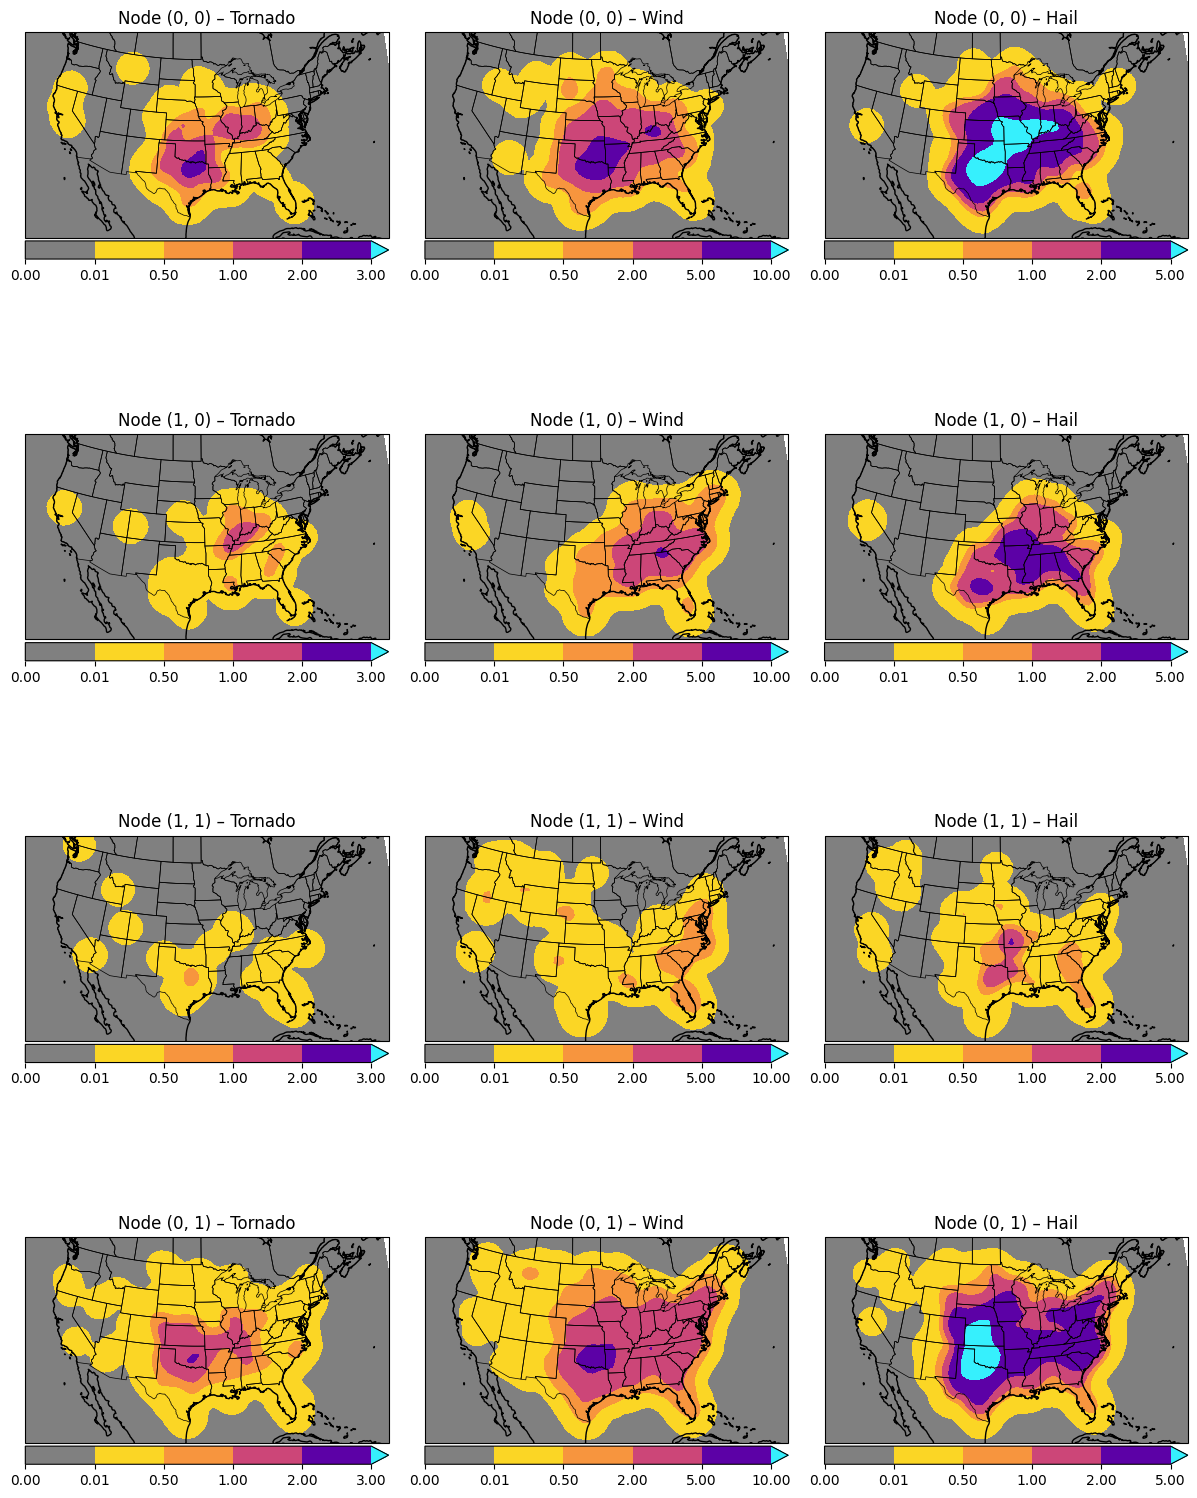

In [475]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axes = plt.subplots(
    nrows=len(win_map_idx), ncols=3,
    figsize=(15, 5 * len(win_map_idx)),
    subplot_kw={'projection': ccrs.LambertConformal()}
)

# Ensure 2D array even if there's only one node
if len(win_map_idx) == 1:
    axes = axes[np.newaxis, :]

# Same color and level settings for all
tor_colors = ['#808080', '#fbd625', '#f7953e', '#cc4678', '#5c01a6', '#36f0fd']
tor_levels = [0.0, 0.01, 0.5, 1.0, 2.0, 3.0]


wind_colors = ['#808080', '#fbd625', '#f7953e', '#cc4678', '#5c01a6', '#36f0fd']
wind_levels = [0.0, 0.01, 0.5, 2.0, 5.0, 10.0]
   
hail_colors = ['#808080', '#fbd625', '#f7953e', '#cc4678', '#5c01a6', '#36f0fd']
hail_levels = [0.0, 0.01, 0.5, 1.0, 2.0, 5.0]

for i, key in enumerate(win_map_idx.keys()):
    date_sel = ds.time[win_map_idx[key]]
    
    # Select previous timestep for each dataset
    tor_sel = ds_tor.sel(time=date_sel.time.values - 1, method='nearest')
    wind_sel = ds_wind.sel(time=date_sel.time.values - 1, method='nearest')
    hail_sel = ds_hail.sel(time=date_sel.time.values - 1, method='nearest')
    
    # Compute means
    tor_mean = tor_sel.p_perfect_tor.mean(dim='time')
    wind_mean = wind_sel.p_perfect_wind.mean(dim='time')
    hail_mean = hail_sel.p_perfect_hail.mean(dim='time')
    
    datasets = [(tor_mean, "Tornado"), (wind_mean, "Wind"), (hail_mean, "Hail")]
    
    for j, (data, title) in enumerate(datasets):
        if title == "Tornado": 
            colors = tor_colors
            levels = tor_levels
        elif title == "Wind":
            colors = wind_colors
            levels = wind_levels
        else:
            colors = hail_colors
            levels = hail_levels
            
        ax = axes[i, j]
        ax.set_extent([-122, -67, 20, 50])
        c = ax.contourf(
            ds_tor.lon, ds_tor.lat, data,
            colors=colors, levels=levels,
            extend= 'max',
            transform=ccrs.PlateCarree()
        )
        ax.add_feature(cfeature.STATES, linewidth=0.5)
        ax.coastlines()
        ax.set_title(f"Node {key} – {title}")
        plt.colorbar(c, ax=ax, orientation='horizontal', extend= 'max',pad=0.01)

fig.subplots_adjust(hspace=0.2, wspace=0.1)
plt.show()


In [476]:
ds_tor
ds_wind
ds_hail

<xarray.Dataset>
Dimensions:         (time: 16436, x: 93, y: 65)
Coordinates:
  * time            (time) datetime64[ns] 1979-01-01T12:00:00 ... 2023-12-31T...
  * x               (x) float64 0.0 1.0 2.0 3.0 4.0 ... 88.0 89.0 90.0 91.0 92.0
  * y               (y) float64 0.0 1.0 2.0 3.0 4.0 ... 60.0 61.0 62.0 63.0 64.0
Data variables:
    lat             (y, x) float64 ...
    lon             (y, x) float64 ...
    p_perfect_hail  (time, y, x) float64 ...
Attributes:
    title:         Practically Perfect Hail Hindcasts
    grid:          80-km NCEP 211
    sigma:         1.5
    author:        Dr. Victor Gensini
    author_email:  vgensini@niu.edu
    citation:      https://doi.org/10.1175/BAMS-D-19-0321.1

In [477]:
times = ds.time.values -1 
ds_tor_sel = ds_tor.sel(time= times, method= 'nearest')
ds_wind_sel = ds_wind.sel(time= times, method= 'nearest')
ds_hail_sel = ds_hail.sel(time= times, method= 'nearest')

In [478]:
tor_mean = ds_tor.p_perfect_tor.mean(dim= 'time')
wind_mean = ds_wind.p_perfect_wind.mean(dim= 'time')
hail_mean = ds_hail.p_perfect_hail.mean(dim= 'time')

tor_std = ds_tor.p_perfect_tor.std(dim= 'time')
wind_std = ds_wind.p_perfect_wind.std(dim= 'time')
hail_std = ds_hail.p_perfect_hail.std(dim= 'time')

In [479]:
tor_std

<xarray.DataArray 'p_perfect_tor' (y: 65, x: 93)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.51499803e-04, 5.14544281e-04, 2.60038586e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.99616247e-03, 3.60831742e-03, 1.90892103e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.61431180e-02, 1.67397326e-02, 9.06249987e-03],
       ...,
       [1.31727679e-01, 7.63787952e-02, 3.20588737e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.13835150e-01, 1.81968974e-01, 7.63787952e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.41259858e-01, 3.13835150e-01, 1.31727679e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * x        (x) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 88.0 89.0 90.0 91.0 92.0
  * y        (y) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 60.0 61.0 62.0 63.0 64.0

In [480]:
tor_colors = ['#808080', '#fbd625', '#f7953e', '#cc4678', '#5c01a6', '#36f0fd']
tor_levels = [0.0, 0.01, 0.5, 1.0, 2.0, 3.0, 100.0]

In [481]:
idx = win_map_idx[(0, 1)]

In [482]:
ds_tor_sel = ds_tor.sel(time= ds.isel(time= idx).time.values, method= 'nearest')

In [483]:
ds_tor_mean = ds_tor_sel.p_perfect_tor.mean(dim= 'time')

In [484]:
tor_stanom = (ds_tor_mean - tor_mean) / tor_std

In [485]:
tor_stanom.fillna(0)

<xarray.DataArray 'p_perfect_tor' (y: 65, x: 93)>
array([[ 0.        ,  0.        ,  0.        , ..., -0.03157448,
        -0.03076974, -0.02501168],
       [ 0.        ,  0.        ,  0.        , ..., -0.03486695,
        -0.03136424, -0.02493837],
       [ 0.        ,  0.        ,  0.        , ..., -0.03646582,
        -0.03149325, -0.02496493],
       ...,
       [-0.01351146, -0.01351146, -0.01351146, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01351146, -0.01351146, -0.01351146, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01351146, -0.01351146, -0.01351146, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
  * x        (x) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 88.0 89.0 90.0 91.0 92.0
  * y        (y) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 60.0 61.0 62.0 63.0 64.0

Text(0.5, 1.0, 'Node (1, 1) p.perfect standardized anomalies - spring')

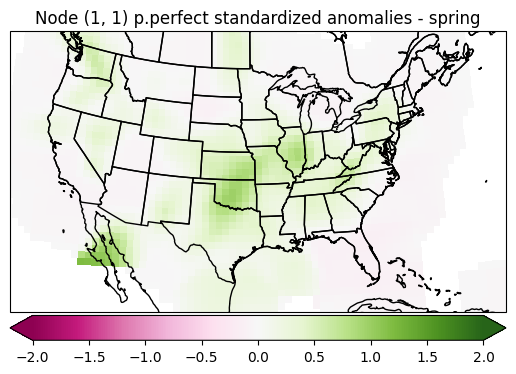

In [486]:
ax = plt.subplot(1, 1, 1, projection= ccrs.LambertConformal())
ax.set_extent([-122, -67, 20, 50])

levels = np.arange(-1.5, 2.0, 0.5)
norm= mcolors.Normalize(vmin= -2.0, vmax= 2.0)


c = ax.pcolormesh(ds_tor.lon, ds_tor.lat, tor_stanom, cmap= 'PiYG', norm= norm, transform= ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.STATES)
plt.colorbar(c, extend= 'both', orientation= 'horizontal', pad= 0.01)

plt.title('Node (1, 1) p.perfect standardized anomalies - spring')

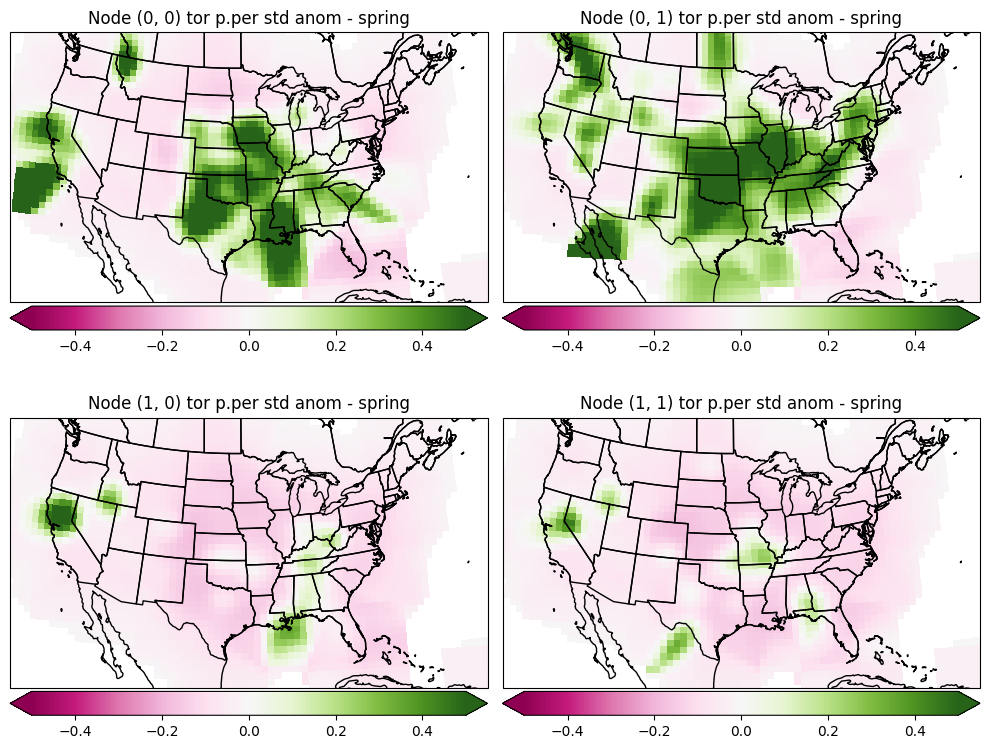

In [487]:
fig, axes = plt.subplots(2, 2, figsize= (10, 8), subplot_kw={'projection': ccrs.LambertConformal()})
norm= mcolors.Normalize(vmin= -0.5, vmax= 0.5)

for i in range(2):
    for j in range(2):
        
        idx = win_map_idx[(i, j)]
        ds_tor_sel = ds_tor.sel(time= ds.isel(time= idx).time.values, method= 'nearest')
        ds_tor_mean = ds_tor_sel.p_perfect_tor.mean(dim= 'time')
        tor_stanom = (ds_tor_mean - tor_mean) / tor_std
        tor_stanom.fillna(0)
        
        ax = axes[i, j]
        ax.set_extent([-122, -67, 20, 50])
        
        c = ax.pcolormesh(ds_tor.lon, ds_tor.lat, tor_stanom, cmap= 'PiYG', norm= norm, transform= ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(cfeature.STATES)
        plt.colorbar(c, extend= 'both', orientation= 'horizontal', pad= 0.01)

        ax.set_title(f'Node ({i}, {j}) tor p.per std anom - spring')
        
        
plt.tight_layout()

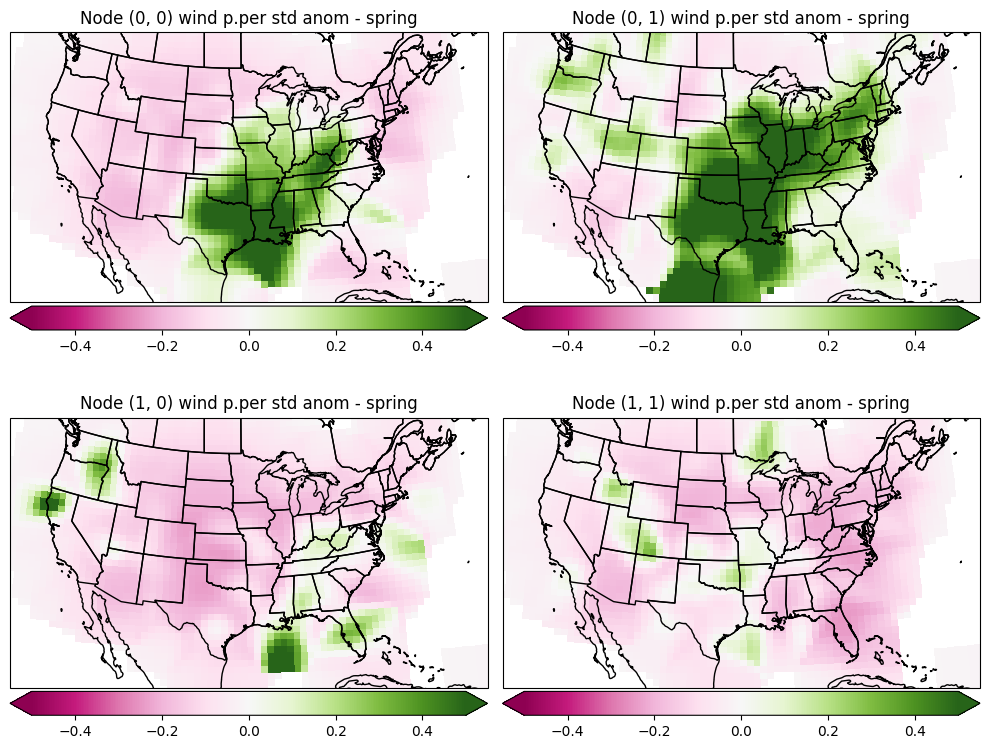

In [488]:
fig, axes = plt.subplots(2, 2, figsize= (10, 8), subplot_kw={'projection': ccrs.LambertConformal()})
norm= mcolors.Normalize(vmin= -0.5, vmax= 0.5)

for i in range(2):
    for j in range(2):
        
        idx = win_map_idx[(i, j)]
        ds_wind_sel = ds_wind.sel(time= ds.isel(time= idx).time.values, method= 'nearest')
        ds_wind_mean = ds_wind_sel.p_perfect_wind.mean(dim= 'time')
        wind_stanom = (ds_wind_mean - wind_mean) / wind_std
        wind_stanom.fillna(0)
        
        ax = axes[i, j]
        ax.set_extent([-122, -67, 20, 50])
        
        c = ax.pcolormesh(ds_wind.lon, ds_wind.lat, wind_stanom, cmap= 'PiYG', norm= norm, transform= ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(cfeature.STATES)
        plt.colorbar(c, extend= 'both', orientation= 'horizontal', pad= 0.01)

        ax.set_title(f'Node ({i}, {j}) wind p.per std anom - spring')
        
        
plt.tight_layout()

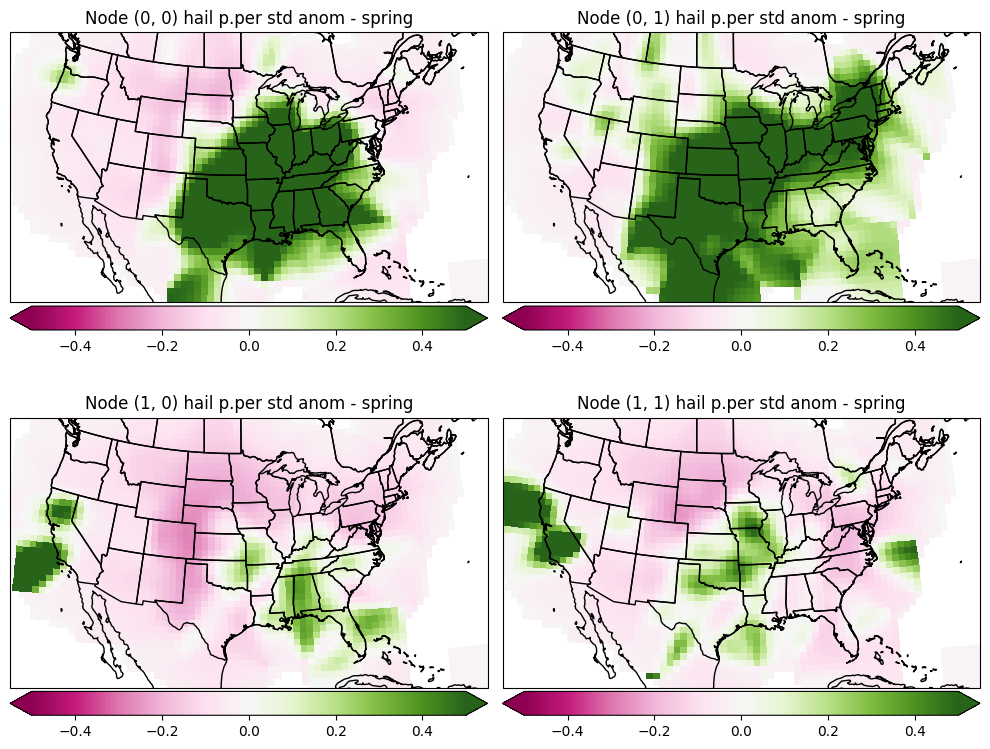

In [489]:
fig, axes = plt.subplots(2, 2, figsize= (10, 8), subplot_kw={'projection': ccrs.LambertConformal()})
norm= mcolors.Normalize(vmin= -0.5, vmax= 0.5)

for i in range(2):
    for j in range(2):
        
        idx = win_map_idx[(i, j)]
        ds_hail_sel = ds_hail.sel(time= ds.isel(time= idx).time.values, method= 'nearest')
        ds_hail_mean = ds_hail_sel.p_perfect_hail.mean(dim= 'time')
        hail_stanom = (ds_hail_mean - hail_mean) / hail_std
        hail_stanom.fillna(0)
        
        ax = axes[i, j]
        ax.set_extent([-122, -67, 20, 50])
        
        c = ax.pcolormesh(ds_hail.lon, ds_hail.lat, hail_stanom, cmap= 'PiYG', norm= norm, transform= ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(cfeature.STATES)
        plt.colorbar(c, extend= 'both', orientation= 'horizontal', pad= 0.01)

        ax.set_title(f'Node ({i}, {j}) hail p.per std anom - spring')
        
        
plt.tight_layout()

In [490]:
ds_tor

<xarray.Dataset>
Dimensions:        (time: 16436, x: 93, y: 65)
Coordinates:
  * time           (time) datetime64[ns] 1979-01-01T12:00:00 ... 2023-12-31T1...
  * x              (x) float64 0.0 1.0 2.0 3.0 4.0 ... 88.0 89.0 90.0 91.0 92.0
  * y              (y) float64 0.0 1.0 2.0 3.0 4.0 ... 60.0 61.0 62.0 63.0 64.0
Data variables:
    lat            (y, x) float64 12.19 12.39 12.58 12.77 ... 57.68 57.49 57.29
    lon            (y, x) float64 -133.5 -132.8 -132.1 ... -51.51 -50.44 -49.39
    p_perfect_tor  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:         Practically Perfect Tor Hindcasts
    grid:          80-km NCEP 211
    sigma:         1.5
    author:        Dr. Victor Gensini
    author_email:  vgensini@niu.edu
    citation:      https://doi.org/10.1175/BAMS-D-19-0321.1

In [491]:
ds_tor

<xarray.Dataset>
Dimensions:        (time: 16436, x: 93, y: 65)
Coordinates:
  * time           (time) datetime64[ns] 1979-01-01T12:00:00 ... 2023-12-31T1...
  * x              (x) float64 0.0 1.0 2.0 3.0 4.0 ... 88.0 89.0 90.0 91.0 92.0
  * y              (y) float64 0.0 1.0 2.0 3.0 4.0 ... 60.0 61.0 62.0 63.0 64.0
Data variables:
    lat            (y, x) float64 12.19 12.39 12.58 12.77 ... 57.68 57.49 57.29
    lon            (y, x) float64 -133.5 -132.8 -132.1 ... -51.51 -50.44 -49.39
    p_perfect_tor  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:         Practically Perfect Tor Hindcasts
    grid:          80-km NCEP 211
    sigma:         1.5
    author:        Dr. Victor Gensini
    author_email:  vgensini@niu.edu
    citation:      https://doi.org/10.1175/BAMS-D-19-0321.1

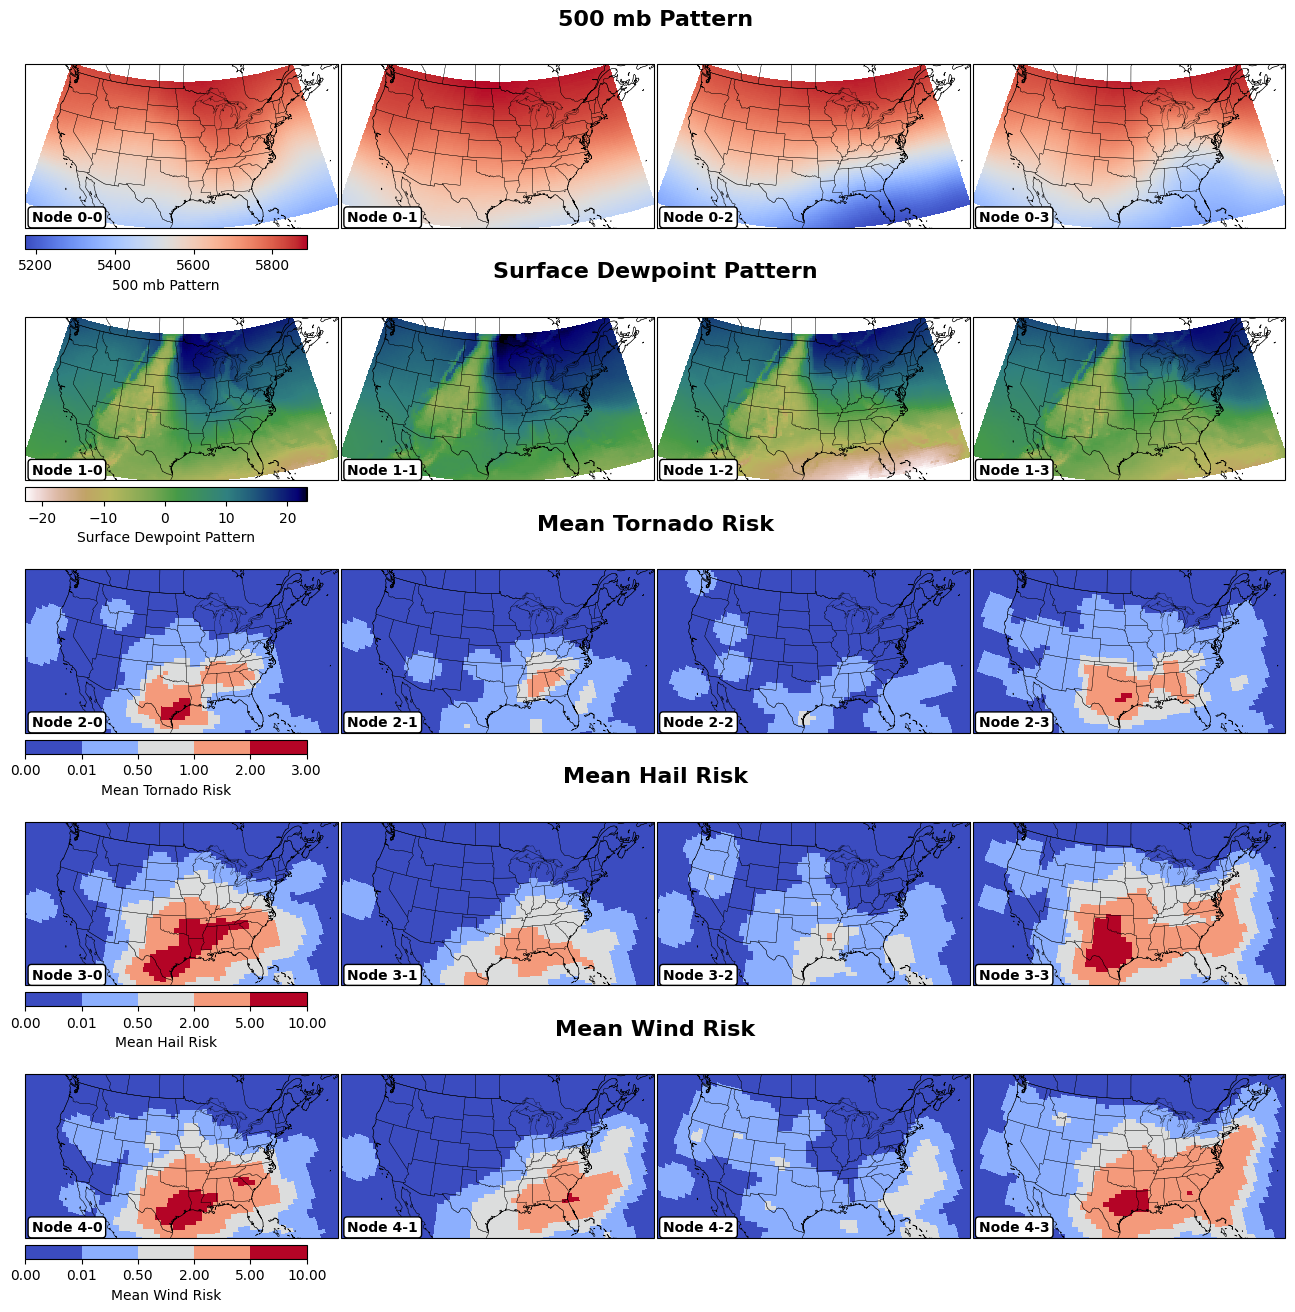

In [492]:
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35)
data_crs = ccrs.PlateCarree()

# Coordinates
lons_data = np.linspace(-125, -66, 171)
lats_data = np.linspace(25, 50, 71)
lon2d_data, lat2d_data = np.meshgrid(lons_data, lats_data)

lons_pp = np.linspace(ds_tor.lon.min(), ds_tor.lon.max(), 93)
lats_pp = np.linspace(ds_tor.lat.min(), ds_tor.lat.max(), 65)
lon2d_pp, lat2d_pp = np.meshgrid(lons_pp, lats_pp)

#Normalization

vmin_z500 = np.min(z500_avg_data)
vmax_z500 = np.max(z500_avg_data)
norm_z500 = mcolors.Normalize(vmin=vmin_z500, vmax=vmax_z500)

vmin_pwat = np.min(pwat_avg_data)
vmax_pwat = np.max(pwat_avg_data)
norm_td2m = mcolors.Normalize(vmin=vmin_pwat, vmax=vmax_pwat)

# Need 5 rows × 4 columns = 20 fields

data_fields = (
    [z500_avg_data[node_idx] for node_idx in range(4)] +
    [pwat_avg_data[node_idx] for node_idx in range(4)] +
    [ds_tor.sel(time=ds.time[win_map_idx[k]].time.values - 1, method='nearest').p_perfect_tor.mean(dim='time') for k in win_map_idx] +
    [ds_hail.sel(time=ds.time[win_map_idx[k]].time.values - 1, method='nearest').p_perfect_hail.mean(dim='time') for k in win_map_idx] +
    [ds_wind.sel(time=ds.time[win_map_idx[k]].time.values - 1, method='nearest').p_perfect_wind.mean(dim='time') for k in win_map_idx]     
)

# Row titles
row_names = [
    "500 mb Pattern",
    "Surface Dewpoint Pattern",
    "Mean Tornado Risk",
    "Mean Hail Risk",
    "Mean Wind Risk"
]

fig, axes = plt.subplots(
    nrows=5, ncols=4,
    figsize=(14, 14),
    subplot_kw={'projection': proj}
)

fig.subplots_adjust(
    left=0.05, right=0.95,
    bottom=0.05, top=0.95,
    hspace=0.01, wspace=0.01
)

fig.patch.set_facecolor('none')
for r in range(5):
    for c in range(4):
        axes[r, c].set_facecolor('none')
        
# Storage for shared colorbars (one list per row)
row_handles = [[] for _ in range(5)]

for idx, (ax, data) in enumerate(zip(axes.flat, data_fields)):
    row = idx // 4
    col = idx % 4

    # Map settings
    ax.set_extent([-125, -66, 25, 50], crs=data_crs)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.STATES, linewidth=0.2)

    # Plot
    if idx < 8:
        lon = lon2d_data
        lat = lat2d_data
    else: 
        lon = lon2d_pp
        lat = lat2d_pp
    if idx < 4:
        cmap= 'coolwarm'
        norm = norm_z500
    elif idx < 8:
        cmap= 'gist_earth_r'
        norm= norm_td2m
    elif idx < 12:
        cmap = plt.cm.coolwarm
        norm = mcolors.BoundaryNorm([0.0, 0.01, 0.5, 1.0, 2.0, 3.0], ncolors= cmap.N)
    elif idx < 20:
        cmap = plt.cm.coolwarm
        norm = mcolors.BoundaryNorm([0.0, 0.01, 0.5, 2.0, 5.0, 10.0], ncolors= cmap.N)
    im = ax.pcolormesh(lon, lat, data, cmap= cmap, norm= norm, transform=data_crs)
    row_handles[row].append(im)

    # Node label (with box)
    ax.text(
        0.02, 0.02, f"Node {row}-{col}",
        transform=ax.transAxes,
        fontsize=10, fontweight='bold',
        va='bottom', ha='left',
        bbox=dict(facecolor='white', edgecolor='black',
                  boxstyle='round,pad=0.25', linewidth=1.0)
    )

# ---- PLACE TITLES ABOVE EACH ROW (centered) ----
for r in range(5):
    # Get vertical midpoint above the row's axes
    y = axes[r, 0].get_position().y1 + 0.012
    fig.text(0.5, y, row_names[r],
             ha='center', va='bottom',
             fontsize=16, fontweight='bold')

# --- Colorbars per row, shifted left under the leftmost axis ---
for r in range(5):

    # Create shared colorbar for the entire row
    cbar = fig.colorbar(
        row_handles[r][0],
        ax=axes[r, :],
        orientation='horizontal',
        fraction=0.04,
        pad=0.06
    )
    cbar.set_label(row_names[r], fontsize=10)

    # --- Reposition the colorbar to align under the *leftmost* axis only ---
    # Get position of leftmost axis in row r
    pos = axes[r, 0].get_position()

    # Resize and shift the colorbar axis
    cbar.ax.set_position([
        pos.x0,               # left align with leftmost axis
        pos.y0 - 0.02,       # shift downward slightly
        pos.width * 0.9,      # shorten bar so it doesn't run across entire row
        0.015                 # bar thickness
    ])

In [493]:
for i in win_map.keys():
    print(i)

(0, 0)
(1, 0)
(1, 1)
(0, 1)


In [494]:
len(z500_avg_data)

4

In [495]:
ds_tor.p_perfect_tor.mean(dim= 'time').max()

<xarray.DataArray 'p_perfect_tor' ()>
array(0.41675429)

In [496]:
[ds_hail.sel(time=ds.time[win_map_idx[k]].time.values - 1, method='nearest').p_perfect_hail.mean(dim='time') for k in win_map_idx]

[<xarray.DataArray 'p_perfect_hail' (y: 65, x: 93)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 Coordinates:
   * x        (x) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 88.0 89.0 90.0 91.0 92.0
   * y        (y) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 60.0 61.0 62.0 63.0 64.0,
 <xarray.DataArray 'p_perfect_hail' (y: 65, x: 93)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 Coordinates:
   * x        (x) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 88.0 89.0 90.0 91.0 92.0
   * y        (y) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 60.0 61.0 62.0 63.0 64.0,
 <xarray.DataArray 'p_perfect_hail' (y: 65, x: 93)>
 a

In [497]:
ds_tor.sel(time=ds.time[win_map_idx[(0, 0)]].time.values - 1, method='nearest').p_perfect_tor.mean(dim='time').max()

<xarray.DataArray 'p_perfect_tor' ()>
array(2.7406909)

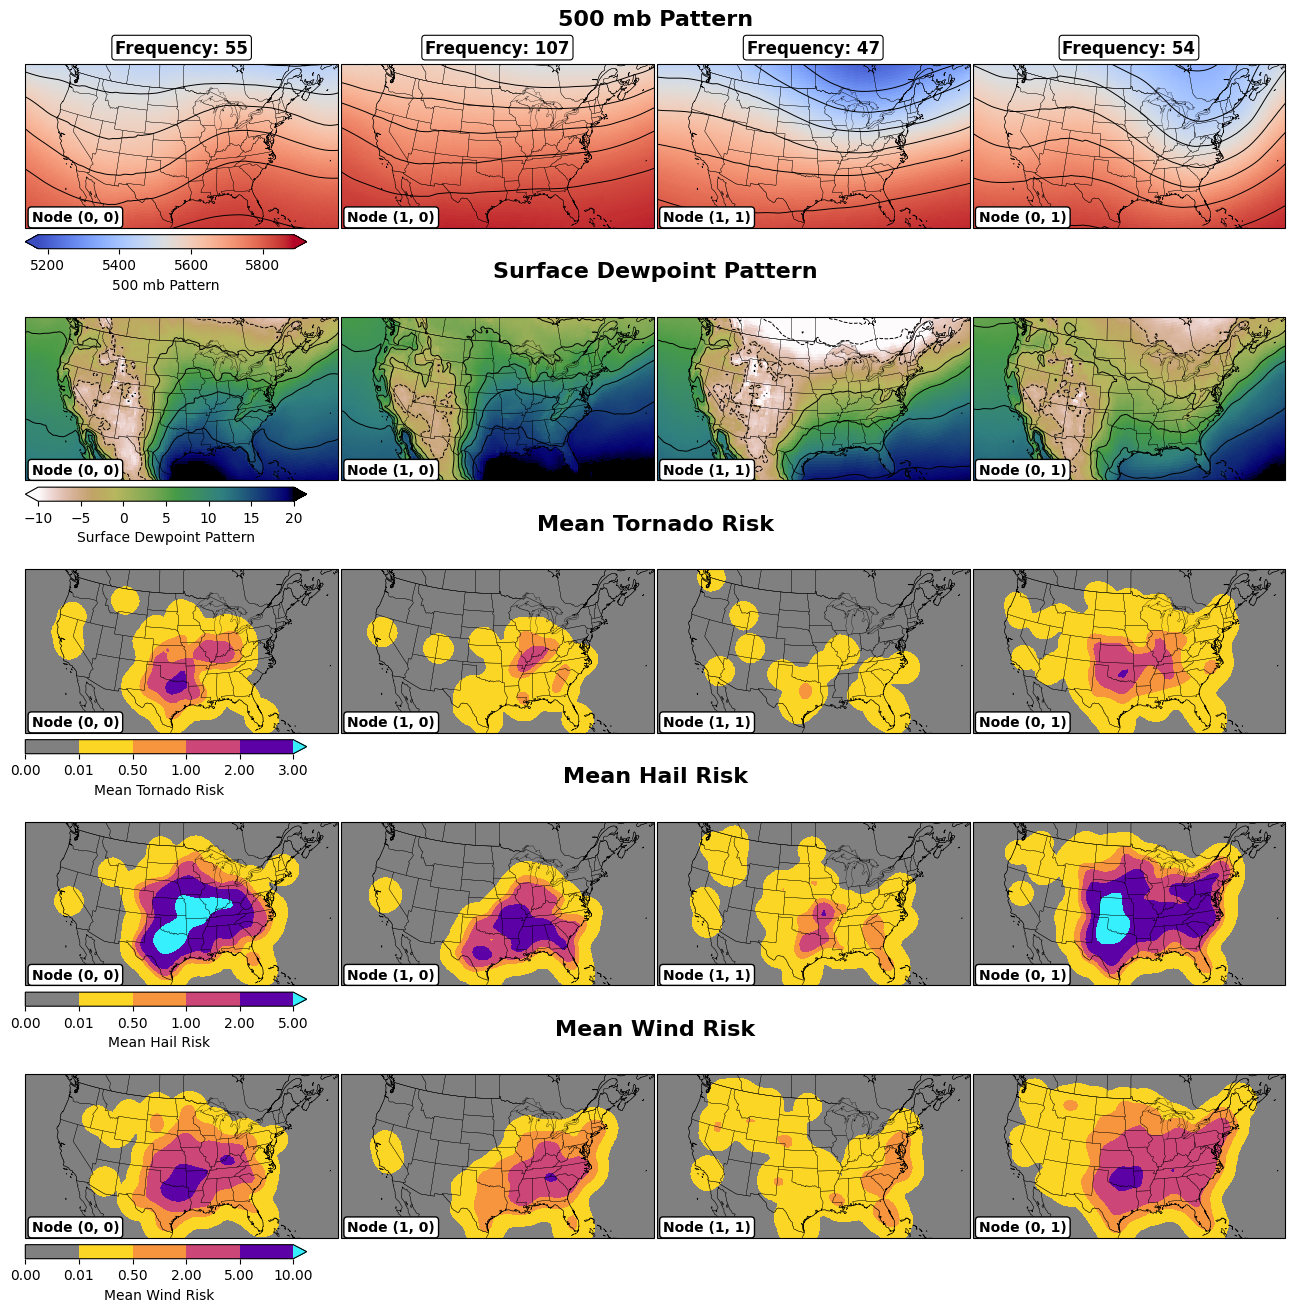

In [503]:
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35)
data_crs = ccrs.PlateCarree()

# Coordinates
# lons_data = np.linspace(-125, -66, 171)
# lats_data = np.linspace(25, 50, 71)
# lon2d_data, lat2d_data = np.meshgrid(lons_data, lats_data)

# lons_pp = np.linspace(-125, -66, 93)
# lats_pp = np.linspace(25, 50, 65)
# lon2d_pp, lat2d_pp = np.meshgrid(lons_pp, lats_pp)

# PP Colors:
tor_colors = ['#808080', '#fbd625', '#f7953e', '#cc4678', '#5c01a6', '#36f0fd']
tor_levels = [0.0, 0.01, 0.5, 1.0, 2.0, 3.0]


wind_colors = ['#808080', '#fbd625', '#f7953e', '#cc4678', '#5c01a6', '#36f0fd']
wind_levels = [0.0, 0.01, 0.5, 2.0, 5.0, 10.0]
   
hail_colors = ['#808080', '#fbd625', '#f7953e', '#cc4678', '#5c01a6', '#36f0fd']
hail_levels = [0.0, 0.01, 0.5, 1.0, 2.0, 5.0]


#Normalization

vmin_z500 = np.min(z500_avg_data)
vmax_z500 = np.max(z500_avg_data)
norm_z500 = mcolors.Normalize(vmin=vmin_z500, vmax=vmax_z500)

vmin_pwat = np.min(pwat_avg_data)
vmax_pwat = np.max(pwat_avg_data)
norm_td2m = mcolors.Normalize(vmin=-10, vmax=20)

# Need 5 rows × 4 columns = 20 fields

data_fields = (
    [z500_avg_data[node_idx] for node_idx in range(4)] +
    [pwat_avg_data[node_idx] for node_idx in range(4)] +
    [ds_tor.sel(time=ds.time[win_map_idx[k]].time.values - 1, method='nearest').p_perfect_tor.mean(dim='time') for k in win_map_idx] +
    [ds_hail.sel(time=ds.time[win_map_idx[k]].time.values - 1, method='nearest').p_perfect_hail.mean(dim='time') for k in win_map_idx] +
    [ds_wind.sel(time=ds.time[win_map_idx[k]].time.values - 1, method='nearest').p_perfect_wind.mean(dim='time') for k in win_map_idx]     
)

# Row titles
row_names = [
    "500 mb Pattern",
    "Surface Dewpoint Pattern",
    "Mean Tornado Risk",
    "Mean Hail Risk",
    "Mean Wind Risk"
]

fig, axes = plt.subplots(
    nrows=5, ncols=4,
    figsize=(14, 14),
    subplot_kw={'projection': proj}
)

fig.subplots_adjust(
    left=0.05, right=0.95,
    bottom=0.05, top=0.95,
    hspace=0.01, wspace=0.01
)

fig.patch.set_facecolor('none')
for r in range(5):
    for c in range(4):
        axes[r, c].set_facecolor('none')
        
# Storage for shared colorbars (one list per row)
row_handles = [[] for _ in range(5)]

for idx, (ax, data) in enumerate(zip(axes.flat, data_fields)):
    row = idx // 4
    col = idx % 4

    # Map settings
    ax.set_extent([-125, -66, 25, 50], crs=data_crs)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.STATES, linewidth=0.2)

    # Plot
    if idx < 8:
        lon = lon2d_data
        lat = lat2d_data
    else: 
        lon = lon2d_pp
        lat = lat2d_pp
    if idx < 4:
        cmap= 'coolwarm'
        norm = norm_z500
        im = ax.pcolormesh(xr_data.lon, xr_data.lat, data, cmap= cmap, norm= norm, transform= data_crs)
        ax.contour(xr_data.lon, xr_data.lat, data, colors = 'k', linewidths= 0.7, transform= data_crs)
    elif idx < 8:
        cmap= 'gist_earth_r'
        norm= norm_td2m
        im = ax.pcolormesh(xr_data.lon, xr_data.lat, data, cmap= cmap, norm= norm, transform= data_crs)
        ax.contour(xr_data.lon, xr_data.lat, data, colors = 'k', linewidths= 0.7, transform= data_crs)
    elif idx < 12:
        im = ax.contourf(ds_tor.lon, ds_tor.lat, data, colors= tor_colors, levels= tor_levels, extend= 'max',  transform= data_crs)
    elif idx < 16:
        im = ax.contourf(ds_hail.lon, ds_hail.lat, data, colors= hail_colors, levels= hail_levels, extend= 'max', transform= data_crs)
    else:
        im = ax.contourf(ds_wind.lon, ds_wind.lat, data, colors= wind_colors, levels= wind_levels, extend= 'max', transform= data_crs)
    # im = ax.pcolormesh(lon, lat, data, cmap= cmap, norm= norm, transform=data_crs)
    row_handles[row].append(im)

    
    
    # Node label (with box)
        # Define consistent node labels for each column
    node_labels = [
        "Node (0, 0)",
        "Node (1, 0)",
        "Node (1, 1)",
        "Node (0, 1)"
    ]

    # Node label (same per column)
    ax.text(
        0.02, 0.02, node_labels[col],
        transform=ax.transAxes,
        fontsize=10, fontweight='bold',
        va='bottom', ha='left',
        bbox=dict(facecolor='white', edgecolor='black',
                  boxstyle='round,pad=0.25', linewidth=1.0)
    )


# ---- PLACE TITLES ABOVE EACH ROW (centered) ----
for r in range(5):
    # Get vertical midpoint above the row's axes
    y = axes[r, 0].get_position().y1 + 0.012
    fig.text(0.5, y, row_names[r],
             ha='center', va='bottom',
             fontsize=16, fontweight='bold')

    
# ---- PLACE NODE FREQUENCIES BELOW EACH COLUMN ----
node_frequencies = z500_frequencies  # example values

for c in range(4):
    # Get midpoint of this column
    x = axes[-1, c].get_position().x0 + axes[-1, c].get_position().width / 2
    
    # Place slightly below the last row of maps
    y = axes[0, c].get_position().y0 + 0.122 # adjust for spacing if needed
    
    fig.text(
        x, y,
        f"Frequency: {int(node_frequencies[c])}",
        ha='center', va='top',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', linewidth=0.8)
    )

# --- Colorbars per row, shifted left under the leftmost axis ---
for r in range(5):

    # Create shared colorbar for the entire row
    cbar = fig.colorbar(
        row_handles[r][0],
        ax=axes[r, :],
        orientation='horizontal',
        extend= 'both',
        fraction=0.04,
        pad=0.06
    )
    cbar.set_label(row_names[r], fontsize=10)

    # --- Reposition the colorbar to align under the *leftmost* axis only ---
    # Get position of leftmost axis in row r
    pos = axes[r, 0].get_position()

    # Resize and shift the colorbar axis
    cbar.ax.set_position([
        pos.x0,               # left align with leftmost axis
        pos.y0 - 0.02,       # shift downward slightly
        pos.width * 0.9,      # shorten bar so it doesn't run across entire row
        0.015                 # bar thickness
    ])
    
# plt.savefig('final_output_white.png', dpi= 300, bbox_inches= 'tight', transparent= False)